In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy import stats
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

# COVID-19 no mundo

Com o intuito de fazermos e respondermos hipóteses sobre o impacto do COVID-19 nos países ao redor do mundo, buscamos dados relevantes de diversos países (como IDH, Temperatura anual média, acesso a água limpa, etc.). A partir desses dados, tentamos entender melhor como diferentes países foram afetados por essa pandemia, assim como ver a possibilidade de prever quais serão os impactos dessa doença em um país baseando-se nas características socioeconômicas e climáticas deste.

## Dados Socioeconômicos e Climáticos  - Busca, tratamento e exploração dos dados

### Obtenção e tratamento dos dados 

Como primeiro passo, buscamos em diversas fontes as informações socioeconômicas e climáticas de diversos países. Como as tabelas encontradas tinham as mais diversas formatações, antes de juntá-las em uma só tabela foram necessários ajustes manuais, de forma a padronizar o nome dos países (que foram usados como identificadores, por serem únicos), e também para remover linhas e colunas com informações não-úteis (como imagens, ou dados muito antigos).  
Vale ressaltar que a primeira padronização dos nomes dos países foi feita pois haviam diferenças entre as tabelas. Por exemplo, algumas possuíam "Viet Nam" e outras "Vietnam", ou "Republic of Moldova" e "Moldova".   
Seguem abaixo os exemplos de algumas das tabelas pós primeiro tratamento:

In [5]:
pd.read_excel('..databases/acesso_agua_aux.xls').head()

,pais,acesso_agua
0,AFGHANISTAN,0.78
1,ALBANIA,0.95
2,ALGERIA,0.84
3,AMERICAN SAMOA,1.00
4,ANDORRA,1.00


In [7]:
pd.read_excel('..databases/IDH_tabela.xlsx').head()

,pais,IDH,expect_vida,escolaridade_media,GNI_per_capita
0,Norway,0.953688,82.271,12.566818,68058.61613
1,Switzerland,0.945936,83.630,13.380812,59374.73403
2,Ireland,0.942473,82.103,12.526295,55659.67902
3,Germany,0.938785,81.180,14.132150,46945.94990
4,Hong Kong,0.938809,84.687,12.038130,60220.79676


In [9]:
pd.read_excel('..databases/DF_aux_tratamento.xls').head()

,pais,acesso_eletricidade,chegada_turistas
0,Afghanistan,98.713203,NaN
1,Angola,43.259258,218000.0
2,Albania,100.000000,5340000.0
3,United Arab Emirates,100.000000,21286000.0
4,Argentina,100.000000,6942000.0


Após a primeira filtragem na formatação e nos nomes dos países das tabelas, todas aquelas que continham informações socioeconômicas foram unidas em um único Dataframe, e o mesmo foi feito para as que continham informações climáticas.  
Depois dessa união em duas grandes tabelas, foi decidido que todos os países que possuíssem algum dado faltante seriam removidos do Dataframe, pois isso poderia atrapalhar as futuras análises.  
Abaixo são expostas as duas tabelas criadas:  

In [12]:
pd.read_csv('..databases/DF_Socioecon_completo.csv', index_col=0)

,IDH,expect_vida,escolaridade_media,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,acesso_eletricidade,chegada_turistas,gasto_saude_per_capita
pais,,,,,,,,,,,
NORWAY,0.95,82.27,12.57,68058.62,5421241.0,15.0,40.0,0.83,1.000,5688000.0,7936.38
SWITZERLAND,0.95,83.63,13.38,59374.73,8654622.0,219.0,43.0,0.74,1.000,10362000.0,9956.26
IRELAND,0.94,82.10,12.53,55659.68,4937786.0,72.0,38.0,0.63,1.000,10926000.0,4976.86
GERMANY,0.94,81.18,14.13,46945.95,83783942.0,240.0,46.0,0.76,1.000,38881000.0,5033.45
AUSTRALIA,0.94,83.28,12.68,44097.02,25499884.0,3.0,38.0,0.86,1.000,9246000.0,5331.82
...,...,...,...,...,...,...,...,...,...,...,...
MOZAMBIQUE,0.45,60.16,3.54,1153.70,31255435.0,40.0,18.0,0.38,0.311,2743000.0,21.07
SIERRA LEONE,0.44,54.31,3.60,1381.30,7976983.0,111.0,19.0,0.43,0.261,57000.0,66.40
BURKINA FASO,0.43,61.17,1.59,1705.49,20903273.0,76.0,18.0,0.31,0.144,144000.0,44.40


In [13]:
pd.read_csv('..databases/DF_Clima_completo.csv', index_col=0)

,acesso_agua,temp_media,area_floresta,precipitacao
pais,,,,
ALGERIA,0.84,22.50,0.01,89.0
ANGOLA,0.75,21.55,0.46,1010.0
ANTIGUA AND BARBUDA,0.98,26.00,0.22,1030.0
ARGENTINA,0.99,14.80,0.10,591.0
ARMENIA,1.00,7.15,0.12,562.0
...,...,...,...,...
UZBEKISTAN,0.98,12.05,0.08,206.0
VENEZUELA,0.95,25.35,0.53,2044.0
VIETNAM,0.99,24.45,0.48,1821.0


Como pode-se observar, nessas duas tabelas os nomes dos países já estão totalmente padronizados (o mesmo país tem o nome igual e em caixa alta nas duas tabelas). Além disso, depois da remoção de países com dados faltantes, o tamanho das duas tabelas divergiu - a socioeconômica ficou com 126 países, enquanto a climática com 156. Mantendo a premissa de remover países com dados faltantes, unimos das duas tabelas e removemos os países "extras" que a tabela climática possuía, originando a primeira versão da tabela a qual utilizamos para as análises desse projeto.  
Segue a primeira versão da tabela que contém todas as informações dos países estudados nesse projeto:

In [18]:
df_worldInfo1 = pd.read_csv('..databases/worldInfo_v1.csv', index_col=0)
df_worldInfo1.sort_index(inplace=True)
df_worldInfo1

,IDH,expect_vida,escolaridade_media,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,acesso_eletricidade,chegada_turistas,gasto_saude_per_capita,acesso_agua,temp_media,area_floresta,precipitacao
pais,,,,,,,,,,,,,,,
ALGERIA,0.76,76.69,7.99,13639.43,43851044.0,18.0,29.0,0.73,1.0000,2657000.0,258.49,0.84,22.50,0.01,89.0
ANGOLA,0.57,60.78,5.13,5554.70,32866272.0,26.0,17.0,0.67,0.4326,218000.0,114.46,0.75,21.55,0.46,1010.0
ANTIGUA AND BARBUDA,0.78,76.89,9.26,22201.23,97929.0,223.0,34.0,0.26,1.0000,269000.0,673.86,0.98,26.00,0.22,1030.0
ARGENTINA,0.83,76.52,10.56,17611.22,45195774.0,17.0,32.0,0.93,1.0000,6942000.0,1324.60,0.99,14.80,0.10,591.0
ARMENIA,0.76,74.94,11.79,9277.23,2963243.0,104.0,35.0,0.63,1.0000,1652000.0,407.64,1.00,7.15,0.12,562.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URUGUAY,0.81,77.77,8.73,19434.85,3473730.0,20.0,36.0,0.96,1.0000,3469000.0,1591.53,1.00,17.55,0.11,1300.0
UZBEKISTAN,0.71,71.57,11.52,6461.84,33469203.0,79.0,28.0,0.50,1.0000,5346000.0,98.82,0.98,12.05,0.08,206.0
VIETNAM,0.69,75.32,8.20,6220.27,97338579.0,314.0,32.0,0.38,1.0000,15498000.0,129.58,0.99,24.45,0.48,1821.0


### Exploração dos dados

Após a criação da tabela de informações socioeconômicas e climáticas dos países, que chamaremos de df_worldInfo, executamos a exploração dos dados presentes nela, de forma a fazer uma última filtragem a fim de retirar tudo aquilo que não fosse útil ou que pudesse atrapalhar as análises a serem feitas.  
O primeiro passo foi gerar a matriz de correlações dos dados da tabela:  

In [20]:
correlacoes = df_worldInfo1.corr()
correlacoes

,IDH,expect_vida,escolaridade_media,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,acesso_eletricidade,chegada_turistas,gasto_saude_per_capita,acesso_agua,temp_media,area_floresta,precipitacao
IDH,1.000000,0.912485,0.900791,0.779223,-0.034233,0.084229,0.872997,0.726090,0.802591,0.379599,0.663816,0.531676,-0.528263,-0.000916,-0.178215
expect_vida,0.912485,1.000000,0.742383,0.687841,-0.017160,0.144306,0.813428,0.648255,0.791890,0.378975,0.603744,0.554323,-0.416691,0.008377,-0.090280
escolaridade_media,0.900791,0.742383,1.000000,0.636420,-0.093365,-0.002857,0.799577,0.598225,0.705199,0.256741,0.585513,0.442032,-0.598945,-0.004908,-0.215866
GNI_per_capita,0.779223,0.687841,0.636420,1.000000,-0.054741,0.089839,0.617969,0.635646,0.450702,0.338709,0.761065,0.393193,-0.377065,-0.112892,-0.270933
pop_total,-0.034233,-0.017160,-0.093365,-0.054741,1.000000,0.029721,0.011879,-0.053377,0.052985,0.354755,-0.021434,0.020048,-0.022373,-0.024118,-0.037143
densidade_pop,0.084229,0.144306,-0.002857,0.089839,0.029721,1.000000,0.070187,0.017282,0.117478,-0.030676,0.016414,0.096841,0.224265,-0.275024,-0.015731
pop_idade,0.872997,0.813428,0.799577,0.617969,0.011879,0.070187,1.000000,0.550829,0.701682,0.429728,0.547061,0.528946,-0.579170,0.052148,-0.184678
pop_urbana,0.726090,0.648255,0.598225,0.635646,-0.053377,0.017282,0.550829,1.000000,0.529621,0.304998,0.511246,0.261367,-0.351533,-0.138018,-0.281128
acesso_eletricidade,0.802591,0.791890,0.705199,0.450702,0.052985,0.117478,0.701682,0.529621,1.000000,0.254559,0.298214,0.536084,-0.353579,0.000666,-0.025818
chegada_turistas,0.379599,0.378975,0.256741,0.338709,0.354755,-0.030676,0.429728,0.304998,0.254559,1.000000,0.377495,0.234872,-0.260639,-0.012025,-0.185865


Na matriz de correlações pudemos perceber que a expectativa de vida (expect_vida) e a escolaridade média (escolaridade_media) são redundantes quando comparadas com o IDH, visto que tem uma correlação de mais de 90% e, por isso, essas colunas foram removidas.  
Além disso achamos interessante ressaltar a **correlação espúria** entre o IDH e a temperatura média (temp_media) dos países, a qual dá a entender que quanto menor for a temperatura, maior será o IDH.

In [22]:
df_worldInfo1.drop(['expect_vida', 'escolaridade_media'], axis=1, inplace=True)
df_worldInfo1.head()

,IDH,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,acesso_eletricidade,chegada_turistas,gasto_saude_per_capita,acesso_agua,temp_media,area_floresta,precipitacao
pais,,,,,,,,,,,,,
ALGERIA,0.76,13639.43,43851044.0,18.0,29.0,0.73,1.0000,2657000.0,258.49,0.84,22.50,0.01,89.0
ANGOLA,0.57,5554.70,32866272.0,26.0,17.0,0.67,0.4326,218000.0,114.46,0.75,21.55,0.46,1010.0
ANTIGUA AND BARBUDA,0.78,22201.23,97929.0,223.0,34.0,0.26,1.0000,269000.0,673.86,0.98,26.00,0.22,1030.0
ARGENTINA,0.83,17611.22,45195774.0,17.0,32.0,0.93,1.0000,6942000.0,1324.60,0.99,14.80,0.10,591.0
ARMENIA,0.76,9277.23,2963243.0,104.0,35.0,0.63,1.0000,1652000.0,407.64,1.00,7.15,0.12,562.0


Após a remoção dessas colunas, decidimos gerar o boxplot de cada uma das colunas restantes, a fim de identificar outliers e entender melhor a distribuição dos dados (os dados foram normalizados para tal plot):

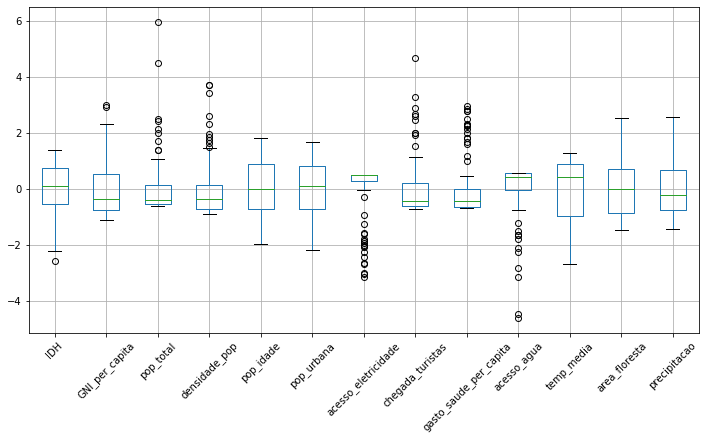

In [24]:
abs_z_scores = stats.zscore(df_worldInfo1)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df_worldInfo1[filtered_entries]

colunas = new_df.columns
x = new_df.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)

new_df = pd.DataFrame(x_scaled, columns=colunas)
plt.figure(figsize=(12,6))
new_df.boxplot(rot=45)
plt.show()

Com o boxplot, pudemos ver que pop_total, densidade_pop, acesso_eletricidade, chegada_turistas, gasto_saude_per_capita e acesso_agua possuem um número mais elevado de outliers.  
Em um primeiro momento, definimos que os outliers de pop_total e densidade_pop fazem sentido, dado que existem países no mundo que são muito mais populosos que outros.  
Em seguida, analisamos o acesso_eletricidade e acesso_agua:

In [25]:
df_worldInfo1['acesso_eletricidade'].describe()

count    116.000000
mean       0.896515
std        0.227046
min        0.144000
25%        0.955150
50%        1.000000
75%        1.000000
max        1.000000
Name: acesso_eletricidade, dtype: float64

In [26]:
df_worldInfo1['acesso_agua'].describe()

count    116.000000
mean       0.964569
std        0.065214
min        0.650000
25%        0.960000
50%        0.990000
75%        1.000000
max        1.000000
Name: acesso_agua, dtype: float64

Pudemos ver que a coluna de acesso à eletricidade não faz sentido, já que é retratado que mais de 75% dos países apresentam grande parte da população (95% ou mais) com acesso à eletricidade, o que não é verdade.  
A mesma análise vale para o acesso à água potável, visto que países como o Brasil estão retratados como se 100% da população possuísse acesso a esse recurso, fato que sabe-se que não é verdadeiro.

In [38]:
df_worldInfo1.drop(['acesso_eletricidade', 'acesso_agua'], axis=1, inplace=True)
df_worldInfo1.head()

,IDH,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,chegada_turistas,gasto_saude_per_capita,temp_media,area_floresta,precipitacao
pais,,,,,,,,,,,
ALGERIA,0.76,13639.43,43851044.0,18.0,29.0,0.73,2657000.0,258.49,22.50,0.01,89.0
ANGOLA,0.57,5554.70,32866272.0,26.0,17.0,0.67,218000.0,114.46,21.55,0.46,1010.0
ANTIGUA AND BARBUDA,0.78,22201.23,97929.0,223.0,34.0,0.26,269000.0,673.86,26.00,0.22,1030.0
ARGENTINA,0.83,17611.22,45195774.0,17.0,32.0,0.93,6942000.0,1324.60,14.80,0.10,591.0
ARMENIA,0.76,9277.23,2963243.0,104.0,35.0,0.63,1652000.0,407.64,7.15,0.12,562.0


Agora, analisamos chegada_turistas e gasto_saude_per_capita e acesso_agua:

In [40]:
df_worldInfo1['chegada_turistas'].sort_values()

pais
MALI                   14000.0
SOLOMON ISLANDS        27900.0
COMOROS                35900.0
SIERRA LEONE           57000.0
PAPUA NEW GUINEA      140000.0
                       ...    
ITALY               61567200.0
CHINA               62900000.0
UNITED STATES       79745920.0
SPAIN               82773000.0
FRANCE              89322000.0
Name: chegada_turistas, Length: 116, dtype: float64

In [41]:
df_worldInfo1['gasto_saude_per_capita'].sort_values()

pais
MOZAMBIQUE          21.07
MADAGASCAR          24.67
ETHIOPIA            25.26
NIGER               29.26
BENIN               30.77
                   ...   
SWEDEN            5904.58
ICELAND           6086.31
NORWAY            7936.38
SWITZERLAND       9956.26
UNITED STATES    10246.14
Name: gasto_saude_per_capita, Length: 116, dtype: float64

No caso desses dois dados, pode-se perceber que os outliers superiores fazem sentido, dado que os países que se configuram como outliers são aqueles que são conhecidamente grandes pontos turísticos (como França e Estados Unidos) ou que são países desenvolvidos, logo possuem maiores investimentos em saúde (como Suíça e Suécia).  
Devido a isso, essas colunas foram mantidas no Dataframe

Por fim, criamos o pairplot e o histograma do Dataframe, a fim de poder analisar visualmente como cada dado está distribuído e como se relacionam entre si:

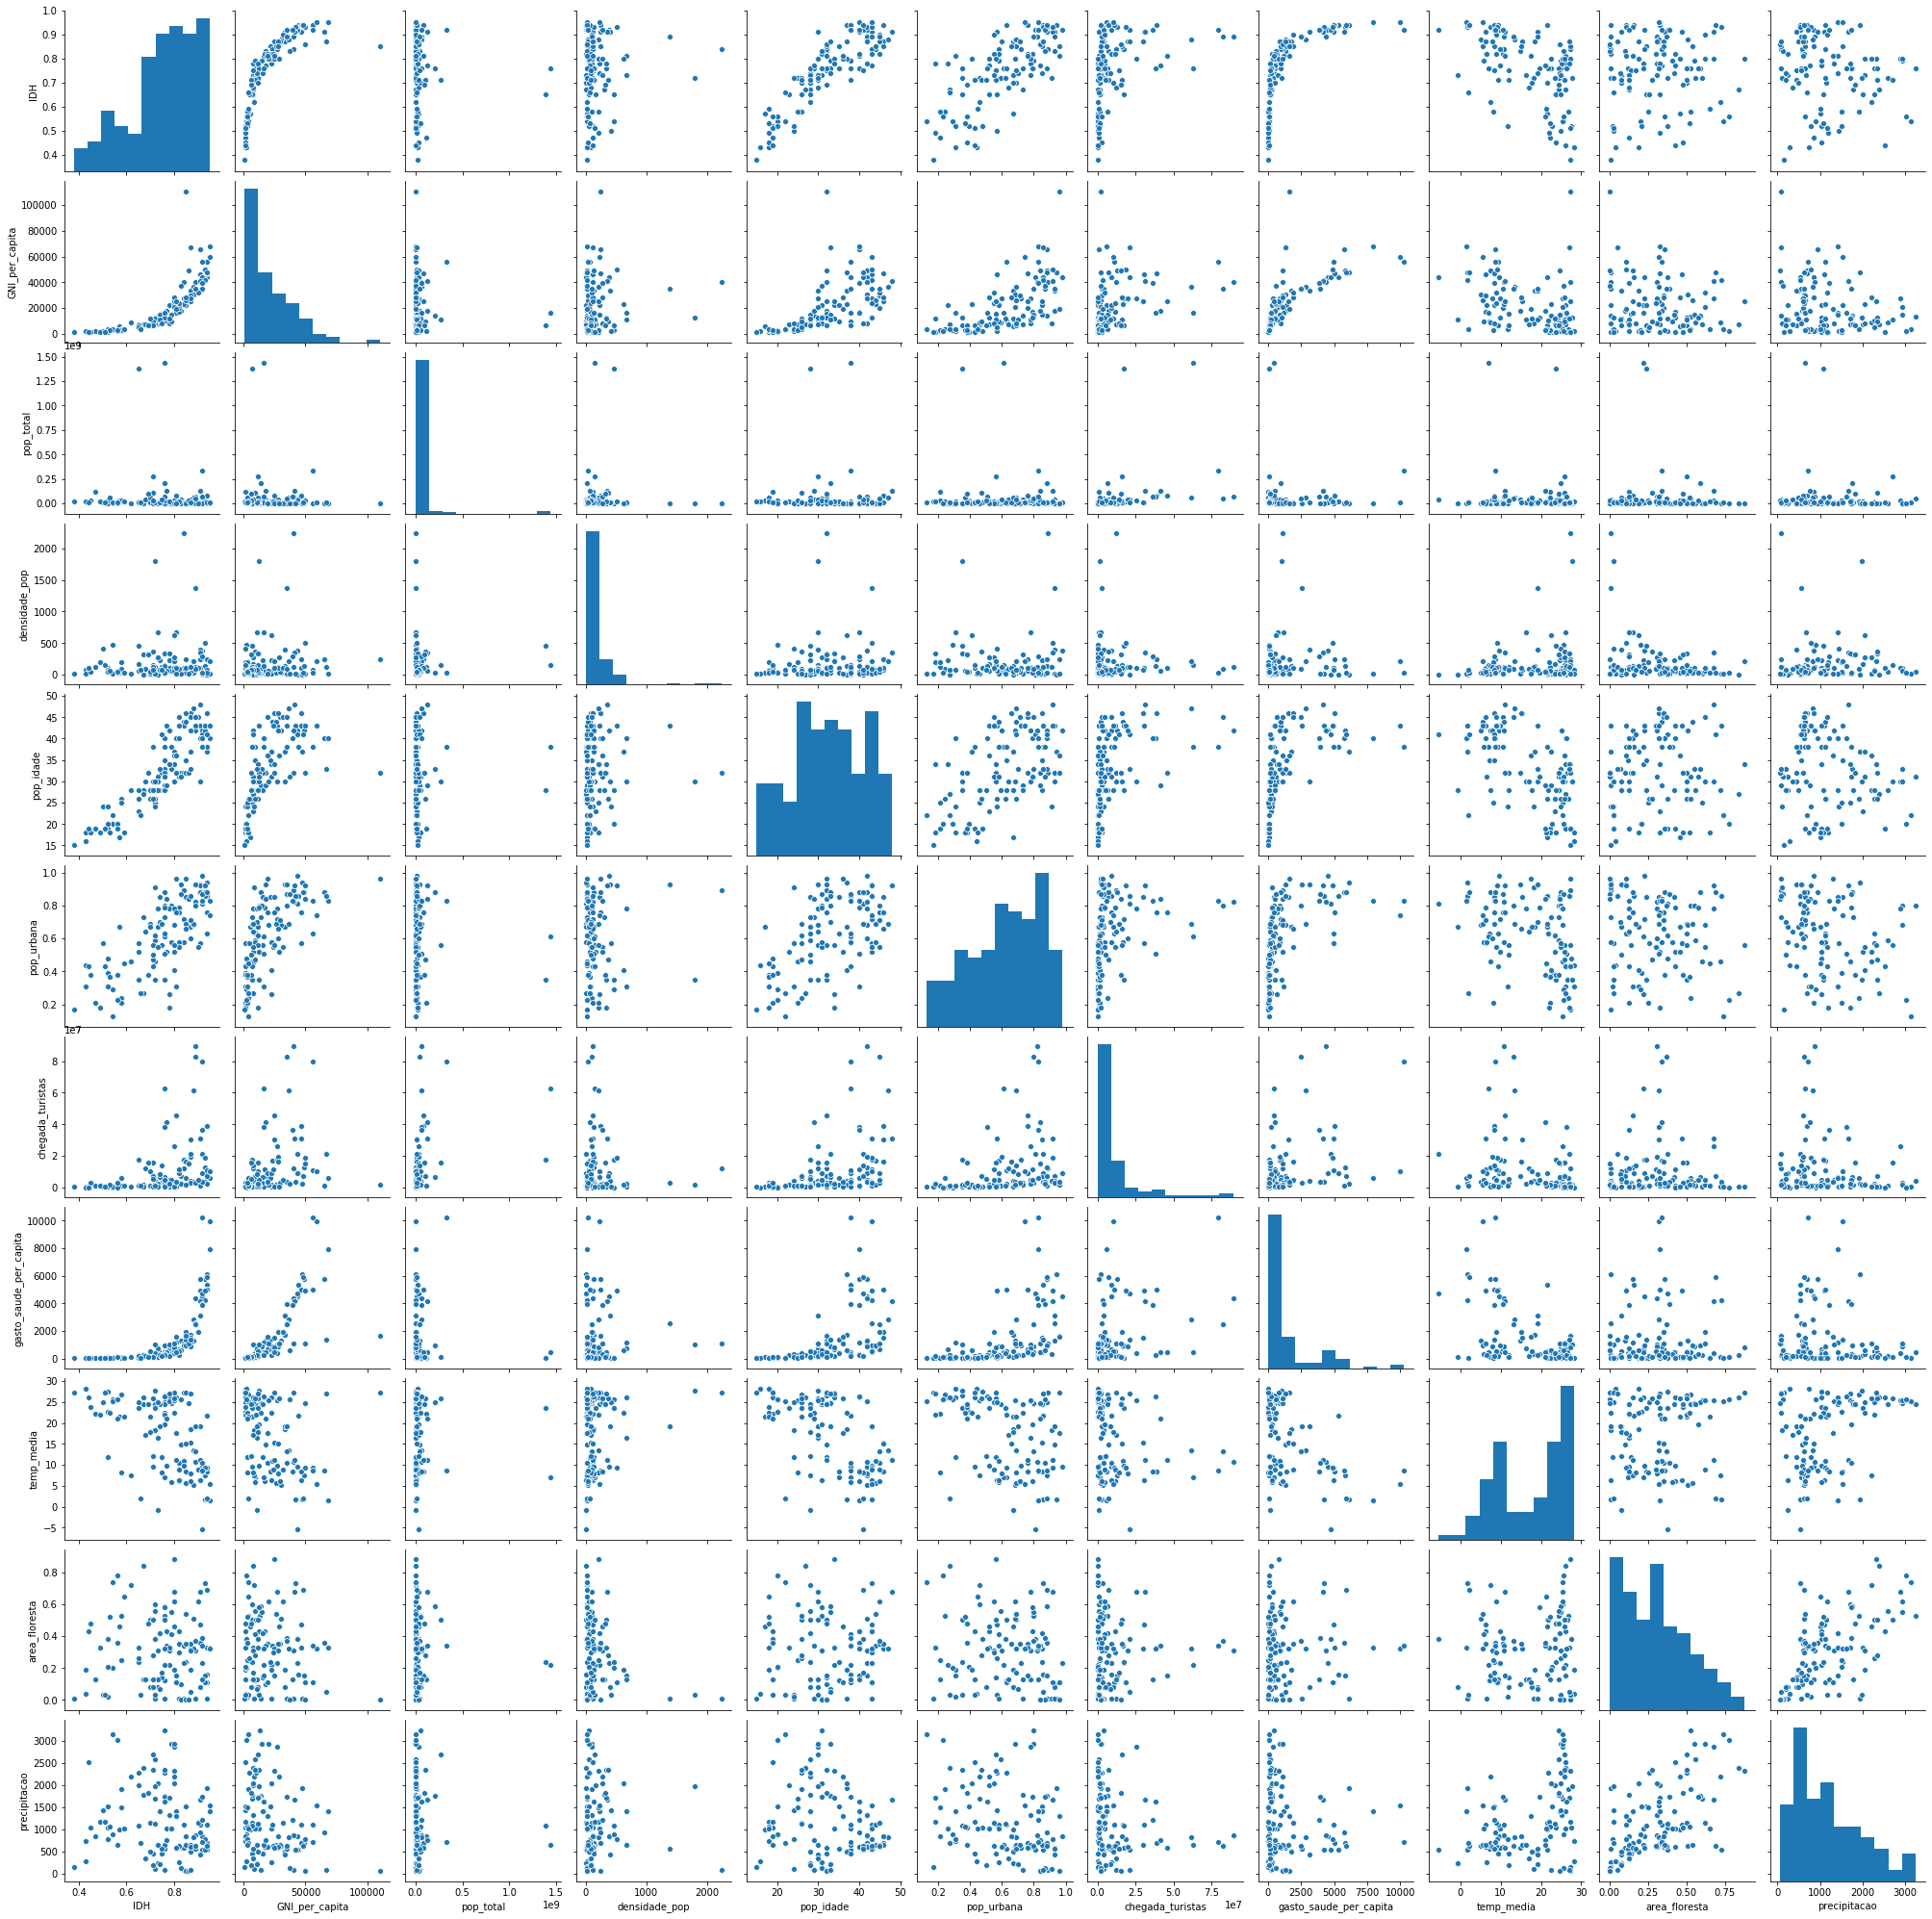

In [48]:
sns.pairplot(df_worldInfo1)

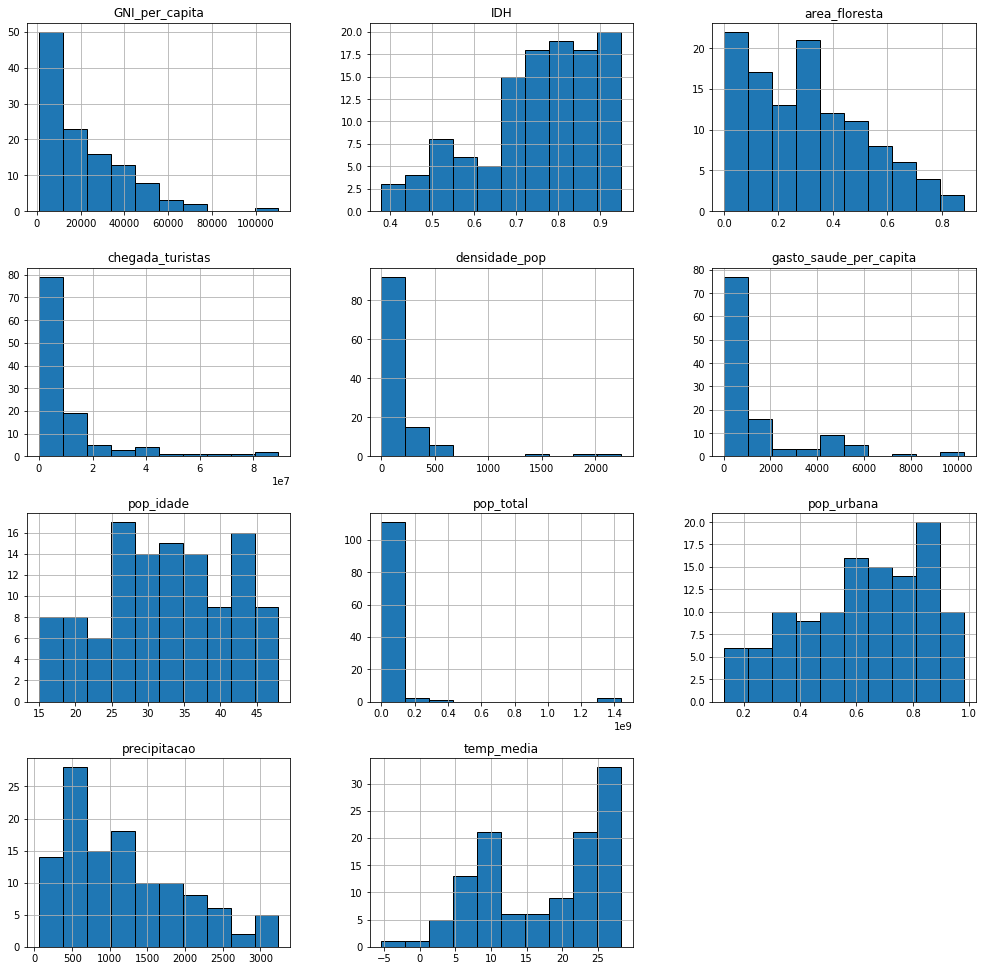

In [49]:
df_worldInfo1.hist(figsize=(17,17), edgecolor='black')
plt.show()

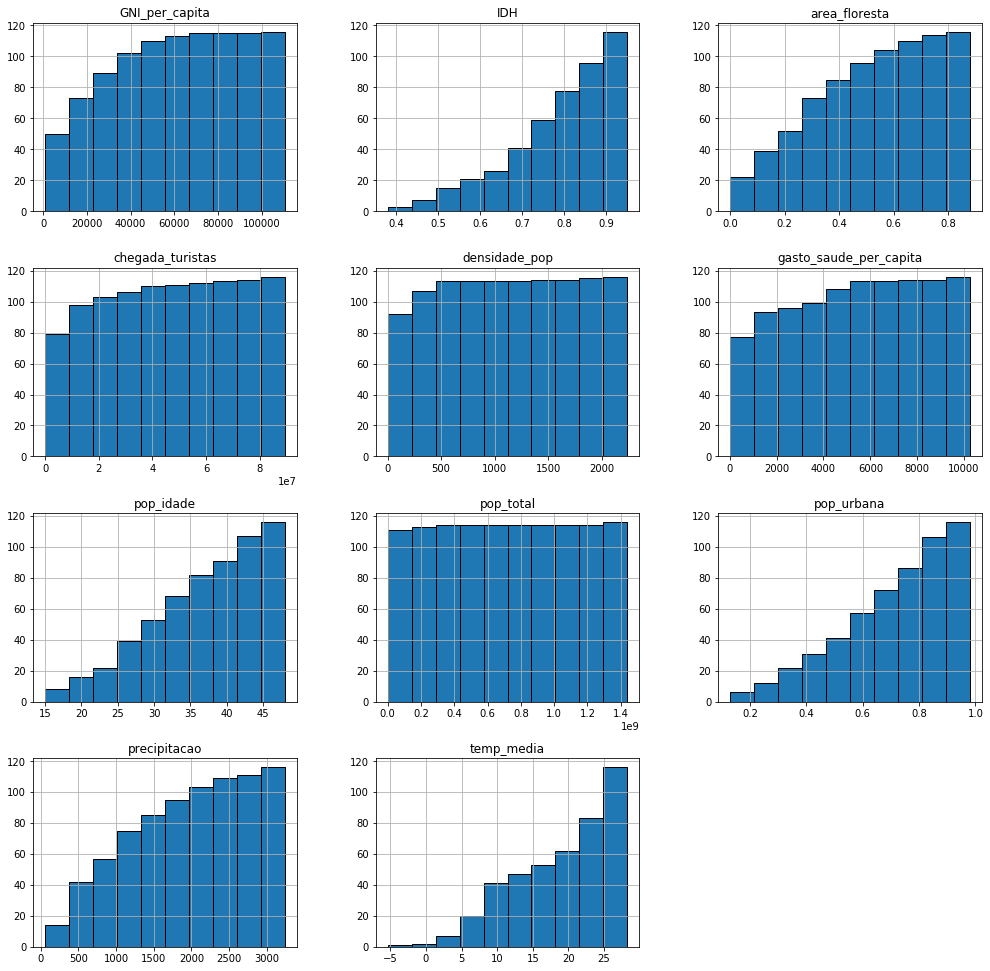

In [50]:
df_worldInfo1.hist(figsize=(17,17), edgecolor='black', cumulative=True)
plt.show()

## Dados COVID-19  - Busca, tratamento e exploração dos dados

### Obtenção e tratamento dos dados 

Para a criação de hipóteses e predições, foi necessário buscarmos os dados do número de casos e de mortes dos países ao redor do mundo. A Organização Mundial da Saúde (OMS) possui uma base de dados que é constantemente atualizada, na qual são armazenados o número de novos casos, o total acumulado de casos, as novas mortes e o total acumulado de mortes por dia de diversos países do mundo:

In [52]:
pd.read_csv('..databases/worldCovid_v1.csv')

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
69555,2020-10-20,ZW,Zimbabwe,AFRO,12,8159,1,232
69556,2020-10-21,ZW,Zimbabwe,AFRO,28,8187,1,233
69557,2020-10-22,ZW,Zimbabwe,AFRO,28,8215,3,236
69558,2020-10-23,ZW,Zimbabwe,AFRO,27,8242,0,236


A fim de adequar a base para nosso uso e para relacioná-la com a tabela de informações previamente obtida, removemos as colunas Country_code e WHO_region pois não teriam uso no nosso contexto.  
Além disso, após a filtragem da tabela de informações socioeconômicas e climáticas nossa base ficou com 116 países, e a tabela com informações sobre a COVID-19 abrange mais países que isso. Dessa forma, removemos todos os países que não seriam utilizados (e foi feita a padronização do nome dos países, a fim de tornar a relação entre as duas tabelas mais prática).
Após esses tratamentos, obtivemos o resultado abaixo:

In [54]:
df_worldCovid1 = pd.read_csv('..databases/worldCovid_v2.csv', index_col=0)
df_worldCovid1

,Date_reported,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,ALGERIA,0,0,0,0
1,2020-01-04,ALGERIA,0,0,0,0
2,2020-01-05,ALGERIA,0,0,0,0
3,2020-01-06,ALGERIA,0,0,0,0
4,2020-01-07,ALGERIA,0,0,0,0
...,...,...,...,...,...,...
34331,2020-10-20,ZIMBABWE,12,8159,1,232
34332,2020-10-21,ZIMBABWE,28,8187,1,233
34333,2020-10-22,ZIMBABWE,28,8215,3,236
34334,2020-10-23,ZIMBABWE,27,8242,0,236


### Exploração dos dados

Como exploração dos dados, já tínhamos em mente que uma curva logística seria o ideal para representar o número total acumulado de casos, como pode ser visto a seguir.

Primeiramente definimos a função que representa uma curva logística:

In [56]:
def logistic_curve(t, a, b, K):
    return K / (1 + a * np.exp(-b*t))

Em seguida, armazenamos os valores de 'a', 'b' e 'K' para cada um dos países (vale lembrar que 't' representa o tempo em dias):

In [57]:
paises = df_worldCovid1[' Country'].unique()
bounds = (0, [10e5,3., 10e12 ])
var_logisticas = {}
erros = []
for pais in paises:
  df_regression = df_worldCovid1[df_worldCovid1[' Country'] == pais]
  df_regression.reset_index(inplace=True, drop=True)
  (a, b, K), cov = curve_fit(logistic_curve,
                            df_regression.index,
                            df_regression[' Cumulative_cases'].values,
                            maxfev=5000,
                            bounds=bounds)
  
  var_logisticas[pais] = (a, b, K)

var_logisticas

{'ALGERIA': (874.1878362195822, 0.03224498248971122, 59053.562838753314),
 'ANGOLA': (9172.152926346787, 0.02835075728849859, 26239.791473177276),
 'ANTIGUA AND BARBUDA': (711534.6453965553,
  0.009638814922693336,
  5792357.618314881),
 'ARGENTINA': (7775.001985511337, 0.03283882892196133, 1520140.9342555872),
 'ARMENIA': (624.5090276186245, 0.03358621575925627, 57076.734191958145),
 'AUSTRALIA': (102.34282643940082, 0.021649103115447273, 35377.22587153344),
 'AUSTRIA': (999999.9286636919, 0.011197909324798491, 2227173477.1516294),
 'AZERBAIJAN': (5121.165793022494, 0.045540124090439255, 41513.433814919874),
 'BAHRAIN': (308.62795419865466, 0.02634209287610095, 86520.33977688783),
 'BARBADOS': (25.986635979997853, 0.015749159045924246, 264.18442249284004),
 'BELARUS': (1417.2921400273224, 0.04918023723858924, 75647.3679064987),
 'BELGIUM': (999041.0144659289, 0.011706682780890076, 6346456665.83204),
 'BELIZE': (999999.9999970562, 0.052601599133379216, 3342.364978663657),
 'BENIN': (11

Após obtermos os valores das variáveis para as curvas logísticas de cada país, plotamos os gráficos das curvas para alguns países, de forma a validar se uma curva logística realmente era a manera ideal de representar os casos totais acumulados:

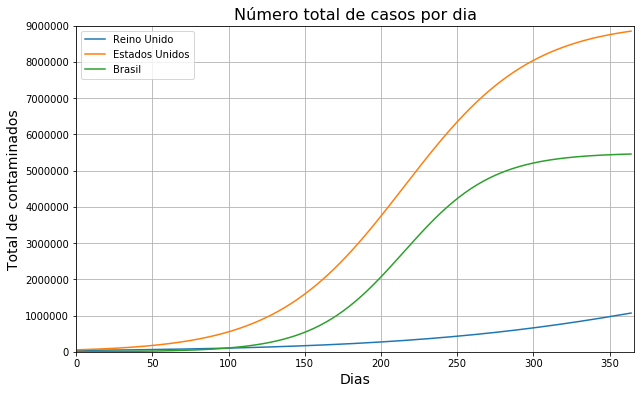

In [73]:
# 3-tupla formada por (a, b, K)
contagio1 = []
contagio2 = []
contagio3 = []
uk = var_logisticas['UNITED KINGDOM']
eua = var_logisticas['UNITED STATES']
br = var_logisticas['BRAZIL']
t= np.array(range(1, 365))
contagio1 =logistic_curve(t, *uk)
contagio2 =logistic_curve(t, *eua)
contagio3 =logistic_curve(t, *br)

plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, 365), y=contagio1, label='Reino Unido')
sns.lineplot(x=range(1, 365), y=contagio2, label='Estados Unidos')
sns.lineplot(x=range(1, 365), y=contagio3, label='Brasil')
plt.title('Número total de casos por dia', fontsize=16)
plt.xlabel('Dias', fontsize=14)
plt.ylabel('Total de contaminados', fontsize=14)
plt.xlim(0, 366)
plt.ylim(0, 9000000)
plt.grid()
plt.legend()
plt.show()

Por fim, plotamos a derivada da curva retratada acima, que nos dá o total de novos casos por dia:

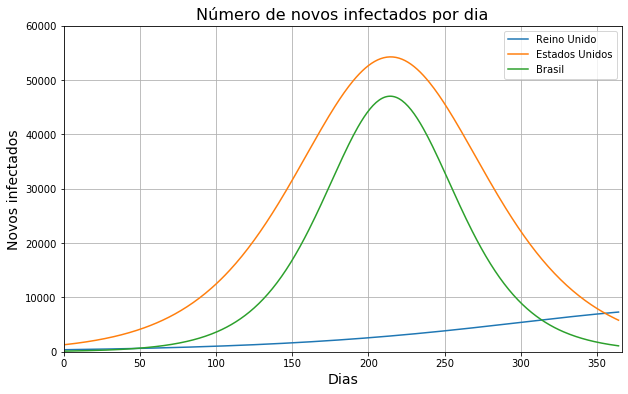

In [71]:
plt.figure(figsize=(10,6))

x1 = range(1,365)
x2 = range(2,365 + 1)
y1 = logistic_curve(x1, *uk)
y2 = logistic_curve(x2, *uk)
sns.lineplot(x=range(1, 365), y=y2-y1, label='Reino Unido')
y1 = logistic_curve(x1, *eua)
y2 = logistic_curve(x2, *eua)
sns.lineplot(x=range(1, 365), y=y2-y1, label='Estados Unidos')
y1 = logistic_curve(x1, *br)
y2 = logistic_curve(x2, *br)
sns.lineplot(x=range(1, 365), y=y2-y1, label='Brasil')

plt.title('Número de novos infectados por dia', fontsize=16)
plt.xlabel('Dias', fontsize=14)
plt.ylabel('Novos infectados', fontsize=14)
plt.xlim(0, 366)
plt.ylim(0, 60000)
plt.grid()
plt.legend()
plt.show()

Pudemos concluir que a curva logística é ideal para retratar os dados de COVID-19. Isso pode ser observado pois a base de dados da OMS que está sendo tratada vai até o dia 24 de Outubro de 2020, e os gráficos acima expressam muito bem como o aumento de casos está ocorrendo hoje (dias após o dia 24 de Outubro).  
Além disso, a função logística nos permite prever como será a evolução da curva. Por exemplo, os gráficos acima foram plotados tomando como base t=365, ou seja, simulando o total de casos e o total de novos infectados diários entre as datas 01 de Março de 2020 e 01 de Março de 2021.

## Previsão do contágio de COVID-19

Após a obtenção de todos os dados descritos acima, nós tentamos criar um modelo de regressão o qual, dado fatores socioeconômicos e climáticos de um país, consiga prever qual será a curva de infecção por COVID-19 daquela localidade.  
Basicamente, teremos que criar um modelo que consiga prever quais serão as variáveis 'a', 'b' e 'K' da curva lógistica que representa a infecção por COVID-19 do país.

Primeiramente, pegamos os dados socioeconômicos e climáticos e normalizamo-os:

In [77]:
X = StandardScaler().fit_transform(df_worldInfo1.values[:, 2:])
y = np.array(list(var_logisticas.values()))

Depois, definimos quais serão os hiperparâmetros utilizados na Cross Validation - ou seja, definimos a listagem de possíveis valores para cada hiperparâmetro e, por meio da Cross Validation, descobrimos quais são os melhores valores para cada um.

In [78]:
eta = np.arange(0.1, 1.1, 0.2)
gamma = [2, 4, 8, 16, 32]
max_depth = [10, 20, 30]

params = {"estimator__eta": eta,
          "estimator__gamma": gamma,
          "estimator__max_depth": max_depth,
          "estimator__booster": ["gbtree", "gblinear" ,"dart"]
}
xgbst = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))
model = GridSearchCV(xgbst, params, cv=5)

Após pegar os melhores hiperparâmetros dentre os que fornecemos como possíveis, fazemos o fit do modelo com os dados normalizados:

In [79]:
multioutputregressor = model.fit(X, y)

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g

C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
C:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will g